In [77]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

Weekly Receiver Stats

In [78]:
weekly = nfl.clean_nfl_data(nfl.import_weekly_data(range(2012, 2023)))
snap_counts = nfl.clean_nfl_data(nfl.import_snap_counts(range(2012, 2023)))
ids = nfl.clean_nfl_data(nfl.import_ids())
ngs = nfl.clean_nfl_data(nfl.import_ngs_data('receiving'))
schedule = nfl.clean_nfl_data(nfl.import_schedules(range(2012, 2023)))

Downcasting floats.


In [79]:
# pbp = nfl.clean_nfl_data(nfl.import_pbp_data(years=range(2012, 2023)))

In [80]:
# pbp.info()

In [129]:
snap_counts = pd.merge(snap_counts[['season', 'week', 'pfr_player_id', 'game_id', 'offense_pct']], ids[['gsis_id', 'pfr_id']], left_on=['pfr_player_id'], right_on=['pfr_id'])

In [130]:
df = pd.merge(weekly, snap_counts, left_on=['season', 'week', 'player_id'], right_on=['season', 'week', 'gsis_id'], how='left')
df.shape

(55126, 57)

In [131]:
df = pd.merge(df, ngs, left_on=['season', 'week', 'player_id'], right_on=['season', 'week', 'player_gsis_id'], how='left', suffixes=('', '_ngs'))
df.shape

(55126, 78)

In [132]:
schedule_cols = ['game_id', 'gameday', 'weekday','gametime', 'away_team', 'home_team', 'location', 'away_moneyline', 'home_moneyline', 'spread_line', 'total_line', 'div_game', 'roof', 'surface', 'temp', 'wind']
df = pd.merge(df, schedule[schedule_cols], left_on=['game_id'], right_on=['game_id'], how='left', suffixes=('', '_schedule'))
df.shape

(55126, 93)

In [133]:
df.set_index(['game_id', 'player_id'], inplace=True)

In [134]:
df.head()

,,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,completions,...,location,away_moneyline,home_moneyline,spread_line,total_line,div_game,roof,surface,temp,wind
game_id,player_id,,,,,,,,,,,,,,,,,,,,,
2012_12_PIT_CLE,00-0000865,None,Charlie Batch,QB,QB,None,PIT,2012,12,REG,20,...,Home,-114.0,103.0,-1.0,33.0,1.0,outdoors,grass,34.0,10.0
2012_13_PIT_BAL,00-0000865,None,Charlie Batch,QB,QB,None,PIT,2012,13,REG,25,...,Home,264.0,-300.0,7.0,36.5,1.0,outdoors,sportturf,57.0,9.0
2012_02_CHI_GB,00-0004541,None,Donald Driver,WR,WR,None,GB,2012,2,REG,0,...,Home,205.0,-230.0,5.0,50.5,1.0,outdoors,grass,60.0,0.0
2012_03_GB_SEA,00-0004541,None,Donald Driver,WR,WR,None,GB,2012,3,REG,0,...,Home,-172.0,155.0,-3.0,45.5,0.0,outdoors,fieldturf,67.0,3.0
2012_04_NO_GB,00-0004541,None,Donald Driver,WR,WR,None,GB,2012,4,REG,0,...,Home,305.0,-350.0,7.5,54.0,0.0,outdoors,grass,64.0,7.0


Receiving Stats

In [135]:
receiving = df[(df['position_group'] == 'WR') & (df['offense_pct'] > 0) & (df['season_type'] == 'REG')].copy()
receiving['y'] = receiving['receptions']
receiving.shape

(17235, 92)

In [136]:
weekly_cols = ['receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_yards_after_catch', 'receiving_air_yards', 'receiving_epa', 'racr', 'target_share', 'air_yards_share', 'wopr', 'offense_pct']
ngs_cols = ['avg_cushion', 'avg_separation', 'avg_intended_air_yards', 'percent_share_of_intended_air_yards', 'catch_percentage', 'avg_yac', 'avg_expected_yac', 'avg_yac_above_expectation']
receiving_cols = weekly_cols + ngs_cols

In [119]:
receiving.dropna(axis=0, subset=receiving_cols, how='all', inplace=True)
receiving.fillna(0, inplace = True)
receiving.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17235 entries, ('2012_02_CHI_GB', '00-0004541') to ('2022_05_LAC_CLE', '00-0036999')
Data columns (total 92 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   player_name                          17235 non-null  object 
 1   player_display_name                  17235 non-null  object 
 2   position                             17235 non-null  object 
 3   position_group                       17235 non-null  object 
 4   headshot_url                         17235 non-null  object 
 5   recent_team                          17235 non-null  object 
 6   season                               17235 non-null  int32  
 7   week                                 17235 non-null  int32  
 8   season_type                          17235 non-null  object 
 9   completions                          17235 non-null  int32  
 10  attempts                           

In [120]:
for col in receiving_cols:
    receiving[col] = receiving.groupby(['player_id', 'season', 'recent_team'])[col].transform(lambda x: x.shift().expanding(min_periods=1).mean())
receiving.dropna(axis=0, subset=receiving_cols, how='all', inplace=True)
receiving.shape

(15483, 92)

In [121]:
receiving = receiving[receiving_cols + ['recent_team', 'y']]
receiving.head()

,,receptions,targets,receiving_yards,receiving_tds,receiving_yards_after_catch,receiving_air_yards,receiving_epa,racr,target_share,air_yards_share,...,avg_cushion,avg_separation,avg_intended_air_yards,percent_share_of_intended_air_yards,catch_percentage,avg_yac,avg_expected_yac,avg_yac_above_expectation,recent_team,y
game_id,player_id,,,,,,,,,,,,,,,,,,,,,
2012_03_GB_SEA,00-0004541,1.000000,1.000000,26.000000,1.000000,2.000000,24.0,2.862955,1.083333,0.031250,0.107143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GB,0
2012_04_NO_GB,00-0004541,0.500000,1.000000,13.000000,0.500000,1.000000,17.0,0.844883,0.541667,0.028783,0.079613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GB,1
2012_05_GB_IND,00-0004541,0.666667,1.333333,9.666667,0.333333,0.666667,16.0,0.422192,0.432540,0.035449,0.067523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GB,1
2012_07_GB_STL,00-0004541,0.750000,1.500000,10.750000,0.250000,0.750000,18.5,0.266665,0.459020,0.042716,0.076233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GB,1
2012_08_JAX_GB,00-0004541,0.800000,1.400000,9.000000,0.200000,0.800000,15.0,-0.032163,0.767216,0.039728,0.061602,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GB,2


In [122]:
receiving.tail()

receptions  targets  receiving_yards  \
game_id         player_id                                          
2022_02_LAC_KC  00-0036988    3.000000      4.0         5.000000   
2022_03_JAX_LAC 00-0036988    3.500000      6.0        17.500000   
2022_04_LAC_HOU 00-0036988    4.333333      7.0        44.666668   
2022_05_LAC_CLE 00-0036988    3.500000      5.5        39.750000   
                00-0036999    1.000000      2.0        19.000000   

                            receiving_tds  receiving_yards_after_catch  \
game_id         player_id                                                
2022_02_LAC_KC  00-0036988       0.000000                     8.000000   
2022_03_JAX_LAC 00-0036988       0.500000                    10.500000   
2022_04_LAC_HOU 00-0036988       0.333333                    24.333334   
2022_05_LAC_CLE 00-0036988       0.250000                    18.750000   
                00-0036999       0.000000                     5.000000   

                            receiving_air_yards  receiving_epa      racr  \
game_id         player_id                                                  
2022_02_LAC_KC  00-0036988            10.000000      -1.917038  0.500000   
2022_03_JAX_LAC 00-0036988            29.500000       0.139822  0.556122   
2022_04_LAC_HOU 00-0036988            41.666668       2.102925  0.870748   
2022_05_LAC_CLE 00-0036988            37.000000       1.960101  0.924800   
                00-0036999            20.000000       1.276127  0.950000   

                            target_share  air_yards_share  ...  avg_cushion  \
game_id         player_id                                  ...                
2022_02_LAC_KC  00-0036988      0.117647         0.042553  ...     0.000000   
2022_03_JAX_LAC 00-0036988      0.145780         0.130165  ...     2.701667   
2022_04_LAC_HOU 00-0036988      0.170357         0.149814  ...     3.675185   
2022_05_LAC_CLE 00-0036988      0.134525         0.133119  ...     2.756389   
                00-0036999      0.066667         0.088106  ...     0.000000   

                            avg_separation  avg_intended_air_yards  \
game_id         player_id                                            
2022_02_LAC_KC  00-0036988        0.000000                0.000000   
2022_03_JAX_LAC 00-0036988        2.243756                3.839375   
2022_04_LAC_HOU 00-0036988        2.690749                5.052546   
2022_05_LAC_CLE 00-0036988        2.018062                3.789410   
                00-0036999        0.000000                0.000000   

                            percent_share_of_intended_air_yards  \
game_id         player_id                                         
2022_02_LAC_KC  00-0036988                             0.000000   
2022_03_JAX_LAC 00-0036988                            12.888134   
2022_04_LAC_HOU 00-0036988                            15.016148   
2022_05_LAC_CLE 00-0036988                            11.262111   
                00-0036999                             0.000000   

                            catch_percentage   avg_yac  avg_expected_yac  \
game_id         player_id                                                  
2022_02_LAC_KC  00-0036988          0.000000  0.000000          0.000000   
2022_03_JAX_LAC 00-0036988         25.000000  1.585000          1.867734   
2022_04_LAC_HOU 00-0036988         38.888889  3.931111          3.113572   
2022_05_LAC_CLE 00-0036988         29.166667  2.948333          2.335179   
                00-0036999          0.000000  0.000000          0.000000   

                            avg_yac_above_expectation  recent_team  y  
game_id         player_id                                              
2022_02_LAC_KC  00-0036988                   0.000000          LAC  4  
2022_03_JAX_LAC 00-0036988                  -0.282734          LAC  6  
2022_04_LAC_HOU 00-0036988                   0.817539          LAC  1  
2022_05_LAC_CLE 00-0036988                   0.613154          LAC  3  
                00-

In [92]:
receiving.describe()

,receptions,targets,receiving_yards,receiving_tds,receiving_yards_after_catch,receiving_air_yards,receiving_epa,racr,target_share,air_yards_share,...,offense_pct,avg_cushion,avg_separation,avg_intended_air_yards,percent_share_of_intended_air_yards,catch_percentage,avg_yac,avg_expected_yac,avg_yac_above_expectation,y
count,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,...,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000
mean,3.432457,5.541092,44.645538,0.274093,15.033516,60.661163,1.346017,0.937028,0.160631,0.213054,...,0.646195,2.045643,0.965805,3.873622,10.412751,21.799367,1.519094,1.392266,0.125879,3.393141
std,1.930282,2.830527,27.222471,0.301867,11.462508,36.133205,2.232546,1.163869,0.079680,0.120806,...,0.239433,2.344206,1.132950,4.737422,13.394126,25.705654,2.071646,1.781544,0.723974,2.558172
min,0.000000,0.000000,-7.000000,0.000000,-5.000000,-14.000000,-17.873531,-1.000000,0.000000,-0.065421,...,0.010000,0.000000,0.000000,-0.460179,-1.638364,0.000000,-2.340000,-1.019344,-5.331798,0.000000
25%,2.000000,3.250000,23.500000,0.000000,6.666667,32.500000,0.000000,0.602182,0.096774,0.118626,...,0.483333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.200000,5.307692,41.750000,0.200000,12.833333,57.000000,1.153782,0.809439,0.155787,0.203878,...,0.700000,0.863265,0.376137,1.218000,2.615252,7.666667,0.267000,0.355658,0.000000,3.000000
75%,4.714286,7.500000,62.000000,0.428571,21.000000,85.000000,2.547112,1.068713,0.219214,0.299588,...,0.844286,4.139408,1.902822,7.486167,19.360561,43.670788,2.745292,2.587466,0.122878,5.000000
max,16.000000,19.000000,208.000000,3.000000,134.000000,282.000000,18.739258,90.000000,0.521739,0.783333,...,1.000000,9.985714,7.018691,33.932000,75.642905,100.000000,29.235000,21.648874,11.210653,17.000000


Statistical Relevance

In [93]:
receiving['outl'] = 0
for col in receiving_cols:
    receiving[f'z_{col}'] = np.abs(stats.zscore(receiving[col]))
    receiving[f'outl_{col}'] = np.where(receiving[f'z_{col}'] >= 3, 1, 0)
    receiving['outl'] = np.where(receiving['outl'], receiving['outl'], receiving[f'outl_{col}'])
    outl = list(np.where(np.abs(receiving[f'z_{col}']) > 3)[0])
    print(f"Total outlier {col}: ", len(outl), "\n")

Total outlier receptions:  67 

Total outlier targets:  40 

Total outlier receiving_yards:  72 

Total outlier receiving_tds:  142 

Total outlier receiving_yards_after_catch:  185 

Total outlier receiving_air_yards:  77 

Total outlier receiving_epa:  202 

Total outlier racr:  92 

Total outlier target_share:  31 

Total outlier air_yards_share:  42 

Total outlier wopr:  27 

Total outlier offense_pct:  0 

Total outlier avg_cushion:  7 

Total outlier avg_separation:  50 

Total outlier avg_intended_air_yards:  77 

Total outlier percent_share_of_intended_air_yards:  70 

Total outlier catch_percentage:  27 

Total outlier avg_yac:  171 

Total outlier avg_expected_yac:  138 

Total outlier avg_yac_above_expectation:  323 



In [94]:
print(receiving.shape)
receiving = receiving[receiving['outl'] == 0]
print(receiving.shape)

(15483, 63)
(14417, 63)


Text(0.5, 1.0, 'Correlation Between Variables')

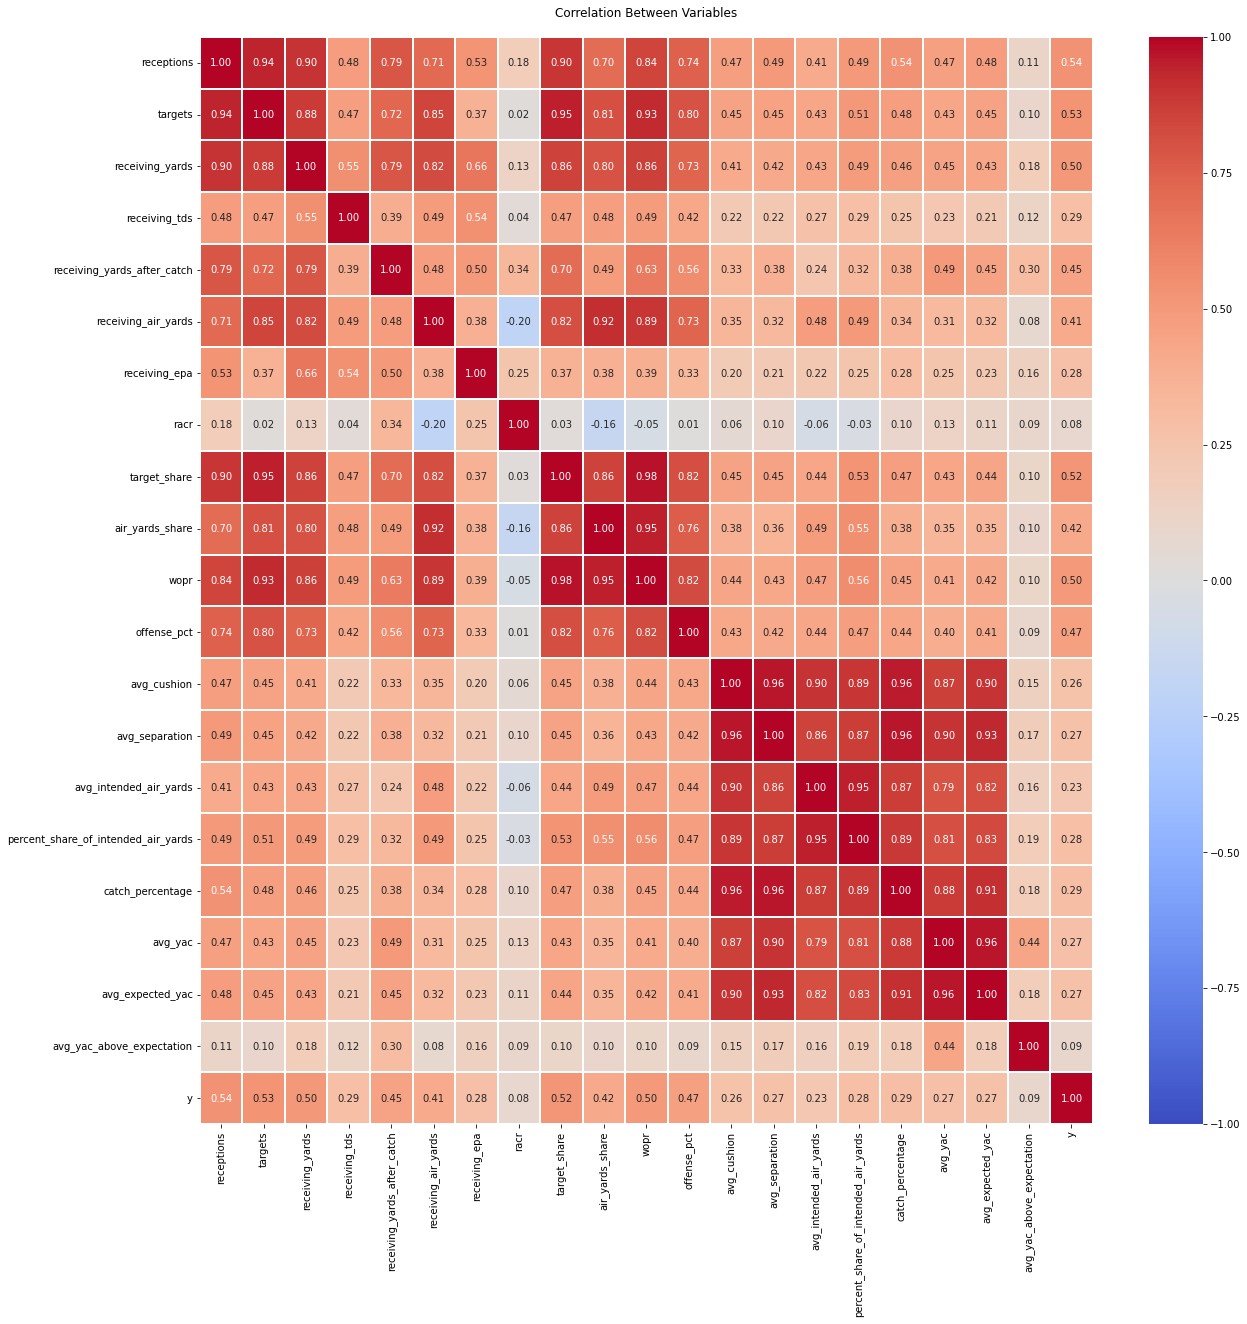

In [95]:
corr = receiving[receiving_cols + ['y']].corr()
plt.figure(figsize = (20, 20))
sns.heatmap(corr, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

In [96]:
receiving.index

MultiIndex([( '2012_03_GB_SEA', '00-0004541'),
            (  '2012_04_NO_GB', '00-0004541'),
            ( '2012_05_GB_IND', '00-0004541'),
            ( '2012_07_GB_STL', '00-0004541'),
            ( '2012_08_JAX_GB', '00-0004541'),
            ( '2012_09_ARI_GB', '00-0004541'),
            ( '2012_11_GB_DET', '00-0004541'),
            ( '2012_16_TEN_GB', '00-0004541'),
            ( '2012_02_DET_SF', '00-0011754'),
            ( '2012_03_SF_MIN', '00-0011754'),
            ...
            ( '2022_05_DET_NE', '00-0036963'),
            ('2022_02_NYJ_CLE', '00-0036980'),
            ('2022_03_CIN_NYJ', '00-0036980'),
            ('2022_04_NYJ_PIT', '00-0036980'),
            ('2022_05_MIA_NYJ', '00-0036980'),
            ( '2022_02_LAC_KC', '00-0036988'),
            ('2022_03_JAX_LAC', '00-0036988'),
            ('2022_04_LAC_HOU', '00-0036988'),
            ('2022_05_LAC_CLE', '00-0036988'),
            ('2022_05_LAC_CLE', '00-0036999')],
           names=['game_id', 'player_id'], 

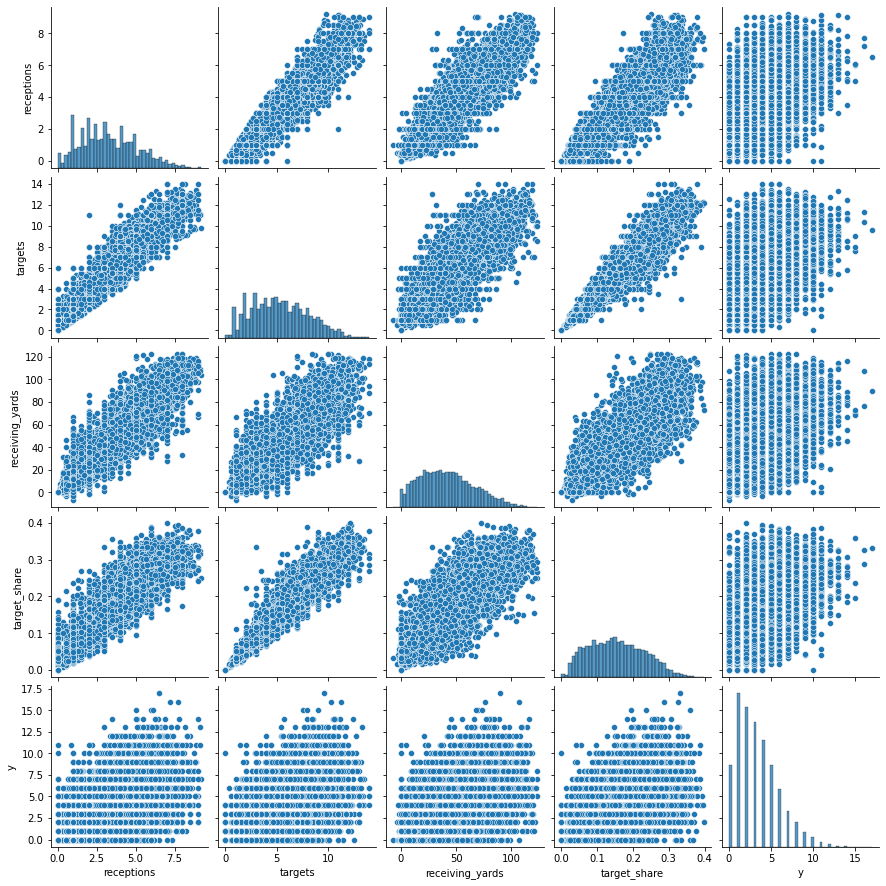

In [104]:
cols = [col for col in receiving_cols if receiving[col].corr(receiving['y']) >= .50] + ['y']
df = receiving[cols]
sns.pairplot(df[cols])

<AxesSubplot:>

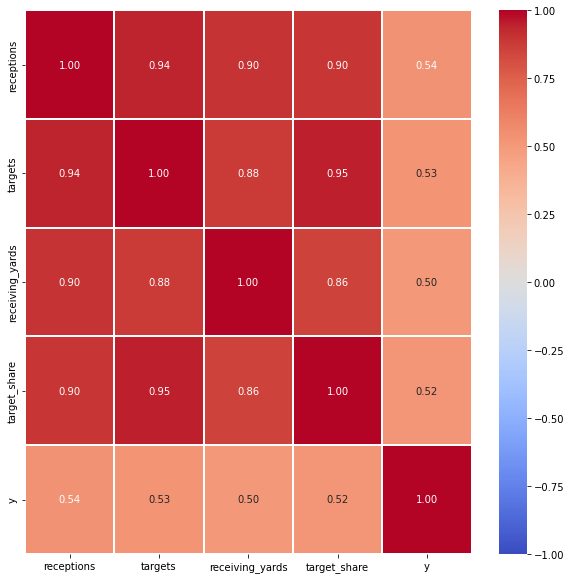

In [105]:
corr = df.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corr, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)

In [106]:
X = df.iloc[:, :-1]
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))
y = df.iloc[:, -1:]

lrmodel = LinearRegression()

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
r2 = np.mean(cross_val_score(lrmodel, X, y, cv=cv, scoring='r2'))
rmse = np.mean(cross_val_score(lrmodel, X, y, cv=cv, scoring='neg_root_mean_squared_error'))
mae = np.mean(cross_val_score(lrmodel, X, y, cv=cv, scoring='neg_mean_absolute_error'))
poisson_dev = np.mean(cross_val_score(lrmodel, X, y, cv=cv, scoring='neg_mean_poisson_deviance'))

c:\Python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Error Analysis

In [107]:
print(f'R2 Score: {round(r2, 2)}')
print(f'RMSE Score: {round(rmse, 2)}')
print(f'MAE Score: {round(mae, 2)}')
print(f'Poisson Deviance Score: {round(poisson_dev, 2)}')

R2 Score: 0.3
RMSE Score: -2.12
MAE Score: -1.64
Poisson Deviance Score: -1.45


<AxesSubplot:ylabel='Frequency'>

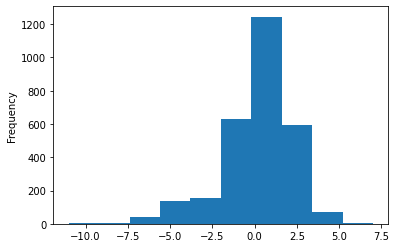

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
lrmodel.fit(X_train, y_train)
y_pred = [round(pred[0]) for pred in lrmodel.predict(X_test)]
error_analysis = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test['y']})
error_analysis['error'] = error_analysis['y_pred'] - error_analysis['y_test']
error_analysis['error'].plot(kind='hist')

In [109]:
error_analysis['error'].skew()

-0.7401975590314653

Prediction

In [137]:
snap_counts = pd.merge(snap_counts[['season', 'week', 'pfr_player_id', 'game_id', 'offense_pct']], ids[['gsis_id', 'pfr_id']], left_on=['pfr_player_id'], right_on=['pfr_id'])
df = pd.merge(weekly, snap_counts, left_on=['season', 'week', 'player_id'], right_on=['season', 'week', 'gsis_id'], how='left')
df = pd.merge(df, ngs, left_on=['season', 'week', 'player_id'], right_on=['season', 'week', 'player_gsis_id'], how='left', suffixes=('', '_ngs'))
schedule_cols = ['game_id', 'gameday', 'weekday','gametime', 'away_team', 'home_team', 'location', 'away_moneyline', 'home_moneyline', 'spread_line', 'total_line', 'div_game', 'roof', 'surface', 'temp', 'wind']
df = pd.merge(df, schedule[schedule_cols], left_on=['game_id'], right_on=['game_id'], how='left', suffixes=('', '_schedule'))
df.set_index(['game_id', 'player_id'], inplace=True)

In [141]:
df[df['player_display_name'] == 'Kenneth Walker'].tail()

player_name player_display_name position position_group  \
game_id player_id                                                            
NaN     00-0038134    K.Walker      Kenneth Walker       RB             RB   
        00-0038134    K.Walker      Kenneth Walker       RB             RB   
        00-0038134    K.Walker      Kenneth Walker       RB             RB   
        00-0038134    K.Walker      Kenneth Walker       RB             RB   

                                                         headshot_url  \
game_id player_id                                                       
NaN     00-0038134  https://static.www.nfl.com/image/private/f_aut...   
        00-0038134  https://static.www.nfl.com/image/private/f_aut...   
        00-0038134  https://static.www.nfl.com/image/private/f_aut...   
        00-0038134  https://static.www.nfl.com/image/private/f_aut...   

                   recent_team  season  week season_type  completions  ...  \
game_id player_id                                                      ...   
NaN     00-0038134         SEA    2022     2         REG            0  ...   
        00-0038134         SEA    2022     3         REG            0  ...   
        00-0038134         SEA    2022     4         REG            0  ...   
        00-0038134         SEA    2022     5         REG            0  ...   

                    location  away_moneyline  home_moneyline  spread_line  \
game_id player_id                                                           
NaN     00-0038134       NaN             NaN             NaN          NaN   
        00-0038134       NaN             NaN             NaN          NaN   
        00-0038134       NaN             NaN             NaN          NaN   
        00-0038134       NaN             NaN             NaN          NaN   

                    total_line  div_game  roof  surface  temp  wind  
game_id player_id                                                    
NaN     00-0038134         NaN       NaN   NaN      NaN   NaN   NaN  
        00-0038134         NaN       NaN   NaN      NaN   NaN   NaN  
        00-0038134         NaN       NaN   NaN      NaN   NaN   NaN  
        00-0038134         NaN       NaN   NaN      NaN   NaN   NaN  

[4 rows x 91 columns]